# Goodwin's oscillator toy model

This example shows how the Goodwin's Oscillator toy model can be used.

Our version of this model has five parameters and three oscillating states as described in [1].

[1] Estimating Bayes factors via thermodynamic integration and population MCMC. Ben Calderhead and Mark Girolami, 2009, Computational Statistics and Data Analysis.

In [1]:
import os
os.chdir("../../")
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import time

model = pints.toy.GoodwinOscillatorModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
real_parameters = model.suggested_parameters()
print(real_parameters)

[ 2.    4.    0.12  0.08  0.1 ]


In the same way, we can get a suggested set of sampling times:

In [3]:
times = model.suggested_times()

Now we can run a simulation:

In [4]:
values = model.simulate(real_parameters, times)

This gives us all we need to create a plot of current versus time:

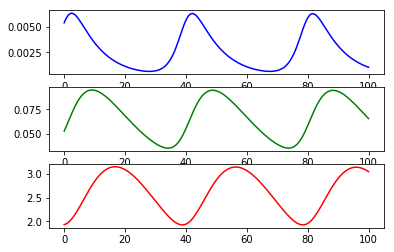

In [5]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, values[:, 2], 'r')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

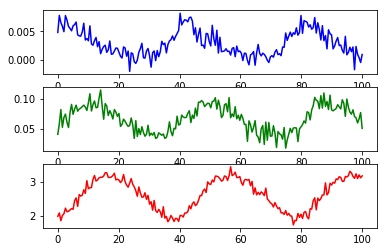

In [6]:
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

Now we can try and infer the original parameters:

In [7]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
chains = mcmc.run()
print('Done!')

end = time.time()
time = end - start

Running


KeyboardInterrupt: 

Print results.

In [8]:
results = pints.MCMCSummary(chains=chains, time=time,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       3.32    1.96    1.65    2.00   2.19   4.32   9.15     1.31    8.87   0.12
k3       4.07    0.86    2.11    3.68   4.08   4.81   5.69     1.36    7.52   0.10
m1       0.21    0.19    0.04    0.12   0.12   0.19   0.75     1.26    8.97   0.12
m2       0.09    0.06    0.03    0.06   0.08   0.09   0.29     1.14    14.35  0.20
m3       0.11    0.03    0.06    0.09   0.10   0.12   0.16     1.04    15.95  0.22


Now we can inspect the resulting chains:

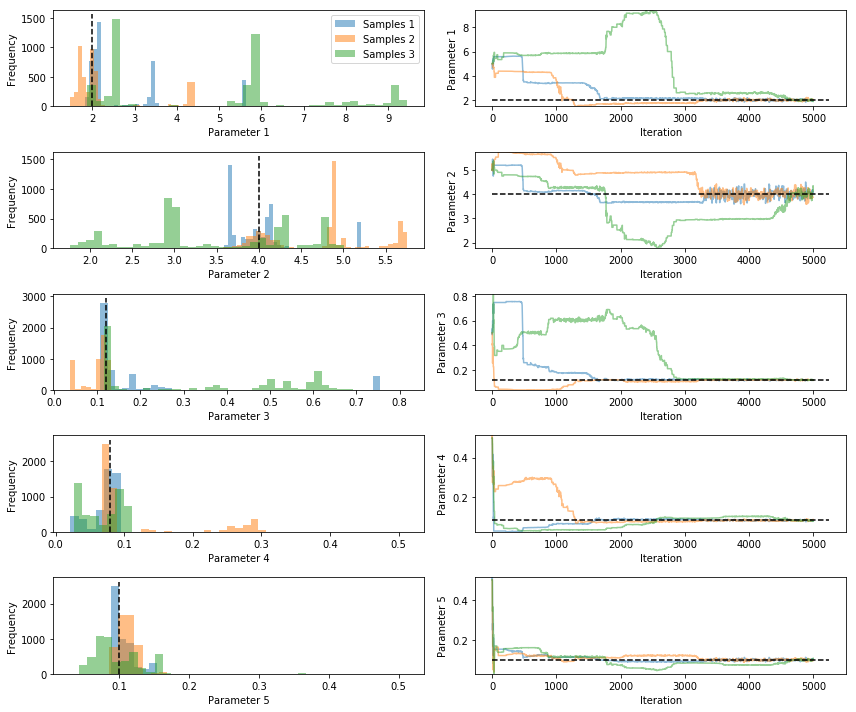

In [9]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

This is a pretty hard problem!

And what about optimisation?

In [10]:
# Fit to the noisy data
parameters = []
opt = pints.OptimisationController(log_posterior, x0[0], method=pints.XNES)
opt.set_log_to_screen(False)
parameters, fbest = opt.run()

print('')
print('            p1       p2       p3       p4       p5')
print('real  ' + ' '.join(['{: 8.4g}'.format(float(x)) for x in real_parameters]))
print('found ' + ' '.join(['{: 8.4g}'.format(x) for x in parameters]))


            p1       p2       p3       p4       p5
real         2        4     0.12     0.08      0.1
found    1.999    4.002     0.12  0.07997   0.1001


## Sampling using relativistic HMC

The Goodwin-oscillator model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Relativistic HMC.

In [ ]:
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0, 0, 0, 0],
    [10, 10, 1, 1, 1, 1, 1, 1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters.tolist() + [noise1, noise2, noise3])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.2,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)

# Run in parallel
mcmc.set_parallel(True)
mcmc.set_log_interval(1)


for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.1, 0.5, 0.002, 0.002, 0.002, 0.0005, 0.001, 0.01])
    sampler.set_leapfrog_steps(10)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
diff = end - start

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     44     0.333     0.333     0.333     0.333      0:00.7
2     84     0.5       0.5       0.5       0.5        0:01.3
3     124    0.6       0.6       0.6       0.6        0:01.8
4     164    0.667     0.667     0.5       0.667      0:02.4
5     204    0.714     0.714     0.571     0.714      0:02.9
6     244    0.75      0.75      0.625     0.75       0:03.5
7     284    0.778     0.778     0.556     0.778      0:04.0
8     324    0.8       0.8       0.6       0.8        0:04.6
9     364    0.727     0.727     0.636     0.818      0:05.1
10    404    0.75      0.75      0.667     0.833      0:05.6
11    444    0.769     0.769     0.692     0.846      0:06.2
12    484    0.714     0.786     0.714     0.857      0:06.7
13    524    0.733     0.8       0.733     0

Print results.

In [ ]:
results = pints.MCMCSummary(chains=chains, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3",
                                             "sigma_x", "sigma_y", "sigma_z"])
print(results)

In [ ]:
pints.plot.trace(chains, ref_parameters=real_parameters1)
plt.show()

Plot posterior predictive distribution.

In [ ]:
pints.plot.series(np.vstack(chains), problem)
plt.show()